In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AutoReg
from sklearn.metrics import mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

import random
import warnings
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA
warnings.filterwarnings("ignore")

# load your time series data into a Pandas DataFrame or Series
data = pd.read_csv("../assets/csv/df_date_item_no.csv", index_col=0)

# data.index.freq = 'D'

data = data.rename_axis('date', axis=1)
# change the datatype of the index to datetime
data.index = pd.to_datetime(data.index, format='%Y-%m-%d')


# split your data into training and testing sets
from sklearn.model_selection import train_test_split
item_name = 'whole milk'
order = '2d'
data = data[[item_name,]].resample(order).sum()
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)
data.head()
#create a test train split
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2, shuffle=False)
len_train = len(train)
len_test = len(test)
print(f"Training Columns: {len_train}\nTesting Columns: {len_test}")


"""
    defining parameter space, since we are use ARMA model, 'd' must be set to 0
"""
PARAMETER_SPACE = {
    'p': range(1, 5),
    'q': range(1, 5)
}


Training Columns: 292
Testing Columns: 73


In [6]:
#find the best parameters of p and q in arima model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def simulated_annealing(train, test, parameter_space, max_iterations=1000, max_no_improv=100):
    """
    Simulated annealing algorithm for finding the best parameters for ARIMA model
    :param train: training data
    :param test: testing data
    :param parameter_space: parameter space for p, d, q
    :param max_iterations: maximum number of iterations
    :param max_no_improv: maximum number of iterations without improvement
    :return: best parameters
    """
    # initialize the best parameters
    best_params = None
    best_score = float("inf")
    # initialize the current parameters
    current_params = {
        'p': random.randint(parameter_space['p'].start, parameter_space['p'].stop - 1),
        'd': 0,
        'q': random.randint(parameter_space['q'].start, parameter_space['q'].stop - 1)
    }
    # initialize the temperature
    t = 1.0
    # initialize the cooling rate
    cooling_rate = 0.003
    # initialize the number of iterations without improvement
    no_improv = 0
    # loop until the maximum number of iterations
    for i in range(max_iterations):
        # check if the number of iterations without improvement is greater than the maximum number of iterations without improvement
        if no_improv > max_no_improv:
            # break the loop
            break
        # make a copy of the current parameters
        new_params = current_params.copy()
        # choose a random parameter to update
        key = random.choice(list(['p', 'q']))
        # choose a random value from the parameter space
        new_params[key] = random.randint(parameter_space[key].start, parameter_space[key].stop - 1)
        # create and fit the ARIMA model
        model = ARIMA(train, order=(new_params['p'], new_params['d'], new_params['q']))
        model_fit = model.fit()
        # make predictions
        yhat = model_fit.predict(len(train), len(train) + len(test) - 1, typ='levels')
        # calculate the mean squared error
        mse = mean_squared_error(test, yhat)
        # check if the mse is less than the best score
        if mse < best_score:
            # update the best score
            best_score, best_params = mse, new_params

    return best_params, best_score

In [7]:
#find the best parameters of p and q in arima model
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
param, score = simulated_annealing(train, test, PARAMETER_SPACE, max_iterations=10, max_no_improv=5)
print(f"Best Parameters: {param}\nBest Score: {score}")

Best Parameters: {'p': 2, 'd': 0, 'q': 2}
Best Score: 13.740027604546343


In [8]:
model_arma = ARIMA(train, order=(param['p'], param['d'], param['q']))
model_arma_fit = model_arma.fit()
forecast = model_arma_fit.forecast(steps=len_test)

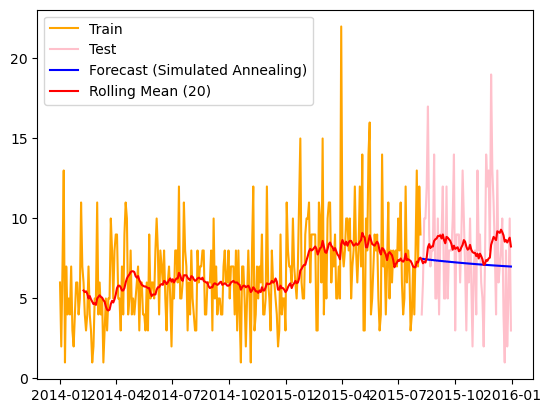

In [13]:
plt.plot(train.index, train, label='Train', color='orange')
plt.plot(test.index, test, label='Test', color = 'pink')
plt.plot(forecast.index, forecast, label='Forecast (Simulated Annealing)', color='blue')

plt.plot(data.rolling(window=20).mean(), color='red', label='Rolling Mean (20)')

plt.legend()
plt.show()  # plot Test, Train and Forecast results

In [14]:
mae = mean_absolute_error(test, forecast)
rmse = np.sqrt(mean_squared_error(test, forecast))
mape = mean_absolute_percentage_error(test, forecast)

print("For Genetic Algorithm")
print(f"MAE: {round(mae,3)}")
print(f"RMSE: {round(rmse,3)}")
print(f"MAPE: {round(mape,3)}%")

For Genetic Algorithm
MAE: 2.921
RMSE: 3.707
MAPE: 0.522%
